<a href="https://colab.research.google.com/github/tseykoroman/ML_for_business/blob/main/Tseyko_Lesson_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1) скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

2) поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

3) сделать разбиение набора данных не тренировочную и тестовую выборки

4) сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

5) провести uplift-моделирование 3 способами:

одна модель с признаком коммуникации (S-learner)

модель с трансформацией таргета

вариант с двумя независимыми моделями

6) в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% 3 моделей

7) *для модели S-learner построить зависимость таргета (конверсии - поле conversion) от значения uplift:

сделать прогноз и получить uplift для тестовой выборки

отсортировать тестовую выборку по uplift по убыванию

разбить на децили (pandas qcut вам в помощь)

для каждого дециля посчитать среднюю conversion

In [136]:
import numpy as np
import pandas as pd

скачать набор данных маркетинговых кампаний отсюда https://www.kaggle.com/davinwijaya/customer-retention

In [137]:
df = pd.read_csv('C:/data.csv')
df.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


поле conversion - это целевая переменная, а offer - коммуникация. Переименовать поля (conversion -> target, offer -> treatment) и привести поле treatment к бинарному виду (1 или 0, т.е было какое-то предложение или нет) - значение No Offer означает отсутствие коммуникации, а все остальные - наличие.

In [138]:
df.rename(columns={'conversion':'target'}, inplace = True)

In [139]:
df.rename(columns={'offer':'treatment'}, inplace = True)

In [140]:
df.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment,target
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [141]:
df['treatment'].unique()

array(['Buy One Get One', 'No Offer', 'Discount'], dtype=object)

In [142]:
mapping = {'Buy One Get One' : 1, 
           'No Offer' : 0, 
           'Discount' : 1}

In [143]:
df['treatment'] = df['treatment'].map(mapping)

In [144]:
df['treatment'].unique()

array([1, 0], dtype=int64)

In [145]:
df.groupby("treatment")['target'].describe()

,count,mean,std,min,25%,50%,75%,max
treatment,,,,,,,,
0,21306.0,0.106167,0.308059,0.0,0.0,0.0,0.0,1.0
1,42694.0,0.167049,0.373024,0.0,0.0,0.0,0.0,1.0


сделать разбиение набора данных не тренировочную и тестовую выборки

In [146]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', axis=1), 
                                                    df['target'], random_state=0)

In [147]:
X_train.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment
1098,8,63.58,1,0,Surburban,1,Phone,1
13764,3,395.35,1,0,Surburban,1,Web,1
45116,4,1307.99,1,1,Rural,1,Phone,1
15363,10,159.01,0,1,Surburban,1,Web,0
44498,1,276.00,1,0,Urban,0,Phone,0


сделать feature engineering на ваше усмотрение (допускается свобода выбора методов)

In [149]:
# X_train = pd.get_dummies(X_train)
# X_test = pd.get_dummies(X_test)
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)

In [150]:
X_train.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,treatment
1098,8,63.58,1,0,Surburban,1,Phone,1
13764,3,395.35,1,0,Surburban,1,Web,1
45116,4,1307.99,1,1,Rural,1,Phone,1
15363,10,159.01,0,1,Surburban,1,Web,0
44498,1,276.00,1,0,Urban,0,Phone,0


провести uplift-моделирование 3 способами:

# **одна модель с признаком коммуникации (S-learner)**


In [152]:
!pip install scikit-uplift catboost

In [153]:
from sklift.models import SoloModel, TwoModels, ClassTransformation
from sklift.metrics import uplift_at_k

from sklearn.ensemble import GradientBoostingClassifier

In [154]:
treat_train = X_train['treatment']
treat_test = X_test['treatment']

cat_features = ['zip_code', 'channel']
models_results = {
    'approach': [],
    'uplift@10%': [],
    'uplift@20%': []
}

In [155]:
X_train = X_train.drop('treatment', axis=1)
X_train

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
1098,8,63.58,1,0,Surburban,1,Phone
13764,3,395.35,1,0,Surburban,1,Web
45116,4,1307.99,1,1,Rural,1,Phone
15363,10,159.01,0,1,Surburban,1,Web
44498,1,276.00,1,0,Urban,0,Phone
...,...,...,...,...,...,...,...
45891,9,34.26,1,0,Urban,0,Phone
52416,5,264.71,1,1,Urban,0,Multichannel
42613,12,419.44,0,1,Urban,1,Multichannel
43567,1,331.56,0,1,Urban,0,Multichannel


In [156]:
X_test = X_test.drop('treatment', axis=1)
X_test

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel
11277,3,466.66,0,1,Urban,1,Phone
55819,8,44.25,0,1,Urban,0,Phone
43223,10,370.84,0,1,Urban,0,Phone
1351,3,114.27,1,0,Urban,1,Web
9247,5,230.93,1,1,Surburban,0,Phone
...,...,...,...,...,...,...,...
9888,8,114.25,0,1,Surburban,1,Web
8672,4,147.40,1,0,Surburban,1,Phone
3849,8,394.16,0,1,Surburban,0,Web
11163,7,275.45,1,0,Rural,0,Phone


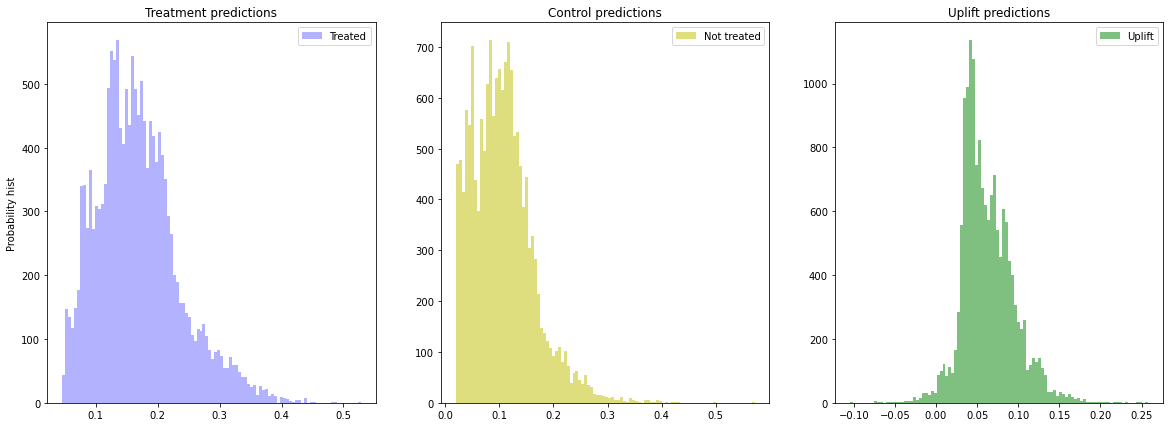

In [157]:
from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel

# sklift поддерживает любые модели, 
# которые удовлетворяют соглашениями scikit-learn
# Для примера воспользуемся catboost
from catboost import CatBoostClassifier


sm = SoloModel(
    CatBoostClassifier(iterations=50, random_state=42, silent=True, cat_features=cat_features)
)

sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)

sm_score_1 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.1)
sm_score_2 = uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('SoloModel')
models_results['uplift@10%'].append(sm_score_1)
models_results['uplift@20%'].append(sm_score_2)

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [158]:
# С той же легкостью можно обратиться к обученной модели.
# Например, чтобы построить важность признаков:
sm_fi = pd.DataFrame({
    'feature_name': sm.estimator.feature_names_,
    'feature_score': sm.estimator.feature_importances_
}).sort_values('feature_score', ascending=False).reset_index(drop=True)

sm_fi

,feature_name,feature_score
0,treatment,17.575450
1,is_referral,15.076992
2,history,14.955890
3,recency,12.296294
4,zip_code,11.768712
5,used_bogo,11.631202
6,used_discount,8.851046
7,channel,7.844414


# **модель с трансформацией таргета**

In [159]:
from sklift.models import ClassTransformation


ct = ClassTransformation(CatBoostClassifier(iterations=50, random_state=42, silent=True, cat_features=cat_features))
ct = ct.fit(X_train, y_train, treat_train)

uplift_ct = ct.predict(X_test)

ct_score_1 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.1)
ct_score_2 = uplift_at_k(y_true=y_test, uplift=uplift_ct, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('ClassTransformation')
models_results['uplift@10%'].append(ct_score_1)
models_results['uplift@20%'].append(ct_score_2)

In [160]:
ct_score_1

0.06297215856039387

In [161]:
ct_score_2

0.05130693307314865


# **вариант с двумя независимыми моделями**

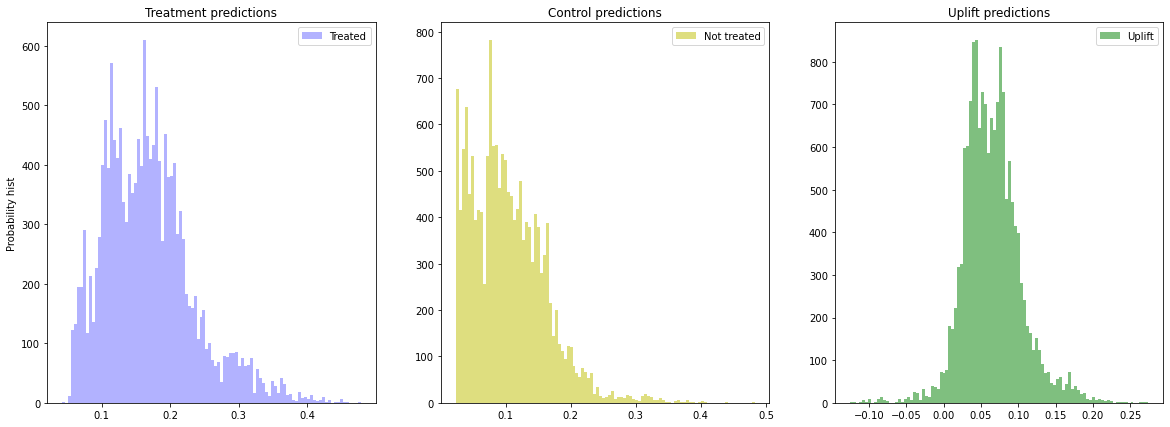

In [162]:
from sklift.models import TwoModels


tm = TwoModels(
        CatBoostClassifier(iterations=50, random_state=42, silent=True, cat_features=cat_features),
        CatBoostClassifier(iterations=50, random_state=42, silent=True, cat_features=cat_features),
    method='vanilla'  # независимые модели
)
tm = tm.fit(
    X_train, y_train, treat_train
)

uplift_tm = tm.predict(X_test)

tm_score_1 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.1)
tm_score_2 = uplift_at_k(y_true=y_test, uplift=uplift_tm, treatment=treat_test, strategy='by_group', k=0.2)

models_results['approach'].append('TwoModels')
models_results['uplift@10%'].append(tm_score_1)
models_results['uplift@20%'].append(tm_score_2)
plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

в конце вывести единую таблицу сравнения метрик uplift@10%, uplift@20% 3 моделей

In [163]:
pd.DataFrame(data=models_results).sort_values('uplift@20%', ascending=False).set_index('approach')


,uplift@10%,uplift@20%
approach,,
TwoModels,0.065078,0.061970
SoloModel,0.050940,0.054449
ClassTransformation,0.062972,0.051307


для модели S learner (модель с дополнительным признаком коммуникации) построить зависимость таргета (конверсии - поле conversion) от значения uplift:  
1) сделать прогноз и получить uplift для тестовой выборки  
2) отсортировать тестовую выборку по uplift по убыванию  
3) разбить на децили (pandas qcut вам в помощь)  
4) для каждого дециля посчитать среднюю conversion  

In [164]:
sm = SoloModel(
    CatBoostClassifier(iterations=50, random_state=42, silent=True, cat_features=cat_features)
)

sm = sm.fit(X_train, y_train, treat_train)

uplift_sm = sm.predict(X_test)

In [177]:
analys_sm = pd.DataFrame()
# analys_sm['uplift'] = sm_trmnt_preds - sm_ctrl_preds
analys_sm['uplift'] = uplift_sm
# analys_sm['target'] = y_train
analys_sm.sort_values('uplift',ascending=False,inplace=True)

In [178]:
analys_sm['decil'] = pd.qcut(analys_sm['uplift'],10,labels=[1,2,3,4,5,6,7,8,9,10])

In [179]:
analys_sm.groupby('decil').mean()

,uplift,target
decil,,
1,0.015531,0.142036
2,0.035471,0.137223
3,0.041168,0.142017
4,0.046500,0.142510
5,0.053542,0.150628
6,0.062131,0.156616
7,0.071319,0.137562
8,0.081506,0.151232
9,0.093485,0.170124
